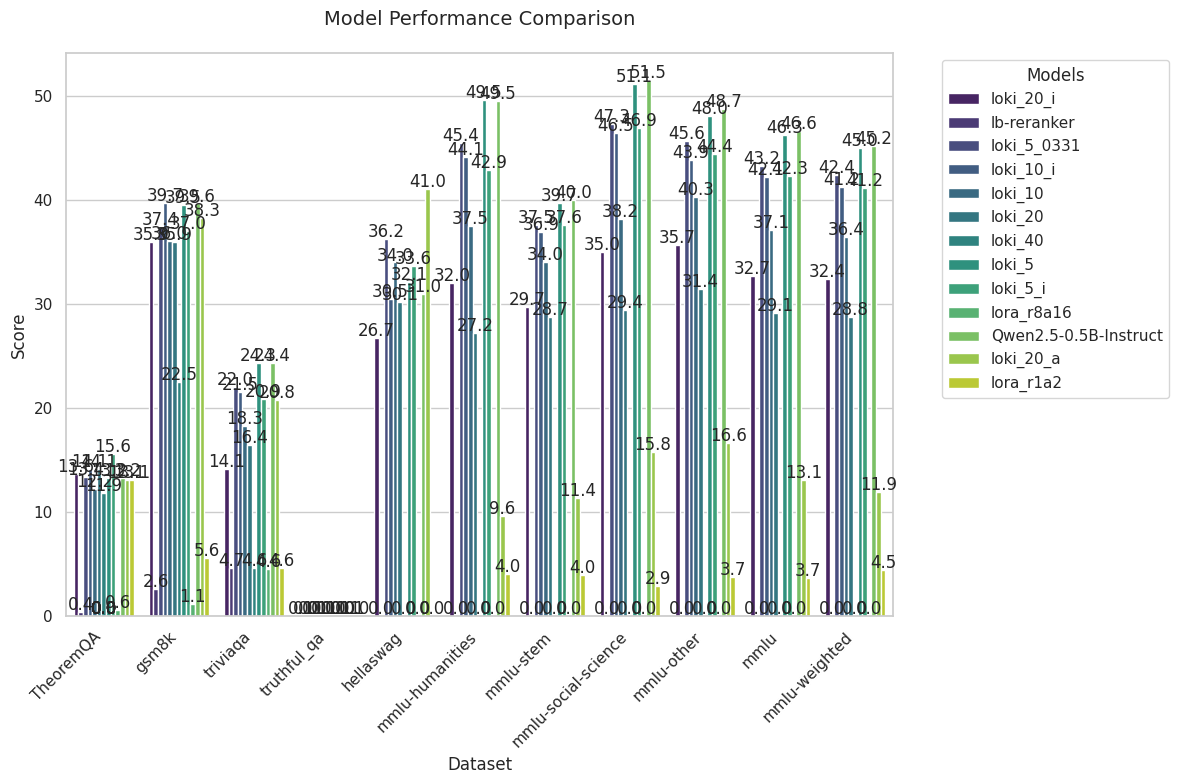

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 配置参数（根据实际路径修改）
input_dir = "/workspace/ftg/evaluate/csv"  # CSV文件存放目录
output_path = "./model_performance.png"  # 输出图片路径
exclude_patterns = ["lukaemon"]  # 需要排除的数据集名称包含的字符串（支持多个）

# 1. 读取并合并所有CSV文件
all_files = Path(input_dir).glob("*.csv")
df_list = []

for f in all_files:
    df = pd.read_csv(f)
    df = df.drop(columns=["version", "metric", "mode"], errors="ignore")
    df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)

# 新增数据集过滤功能
if exclude_patterns:
    # 创建包含所有排除模式的正则表达式
    pattern = '|'.join(exclude_patterns)
    # 过滤数据集名称不包含指定字符串的记录
    mask = ~merged_df['dataset'].str.contains(pattern, case=False, na=False)
    merged_df = merged_df[mask]

# 2. 数据预处理
model_columns = [col for col in merged_df.columns if col != "dataset"]

# 剩余代码保持不变...
plot_df = pd.melt(
    merged_df,
    id_vars=["dataset"],
    value_vars=model_columns,
    var_name="model",
    value_name="score"
)

# 3. 创建可视化图表
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    x="dataset",
    y="score",
    hue="model",
    data=plot_df,
    palette="viridis",
    errorbar=None
)

# 美化图表格式（保持不变）...
plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

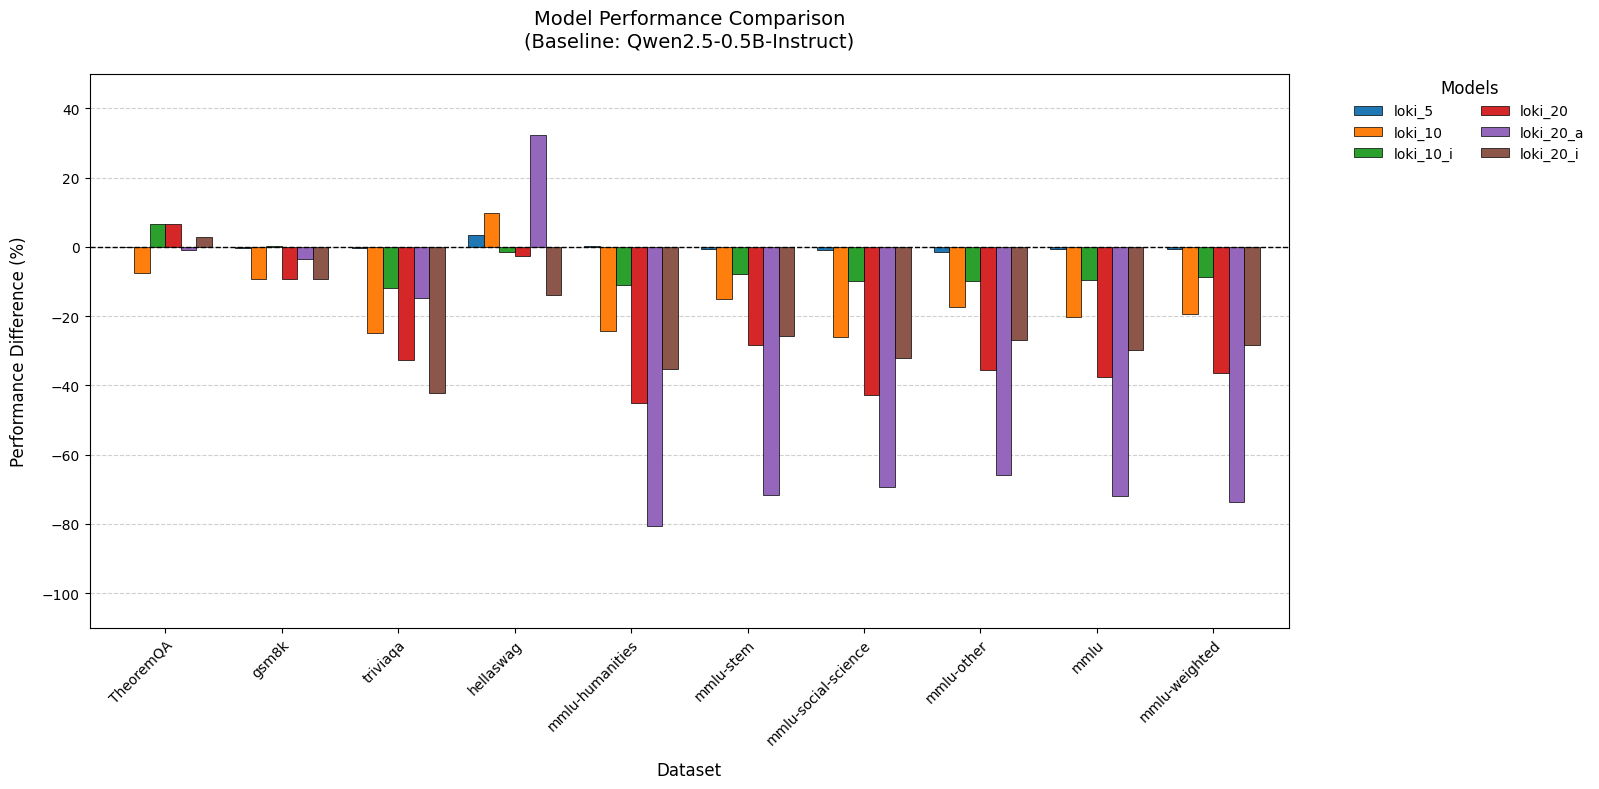

In [21]:
import json
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict


def visualize_model_comparison(folder_path, baseline_model, exclude_strs=None, model_order=None):
    """
    可视化模型性能对比（支持新版JSON格式）

    参数:
    folder_path: str - 包含JSON文件的文件夹路径
    baseline_model: str - 基线模型名称
    exclude_strs: list - 需要排除的数据集包含的字符串列表
    """
    # 获取所有JSON文件路径
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    if not json_files:
        raise ValueError(f"目录中未找到JSON文件: {folder_path}")

    # 读取并合并数据
    all_data = defaultdict(dict)
    for file_path in json_files:
        # 从文件名获取模型名称
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        
        with open(file_path, "r") as f:
            try:
                data = json.load(f)
            except (json.JSONDecodeError, UnicodeDecodeError) as e:
                print(f"警告: 文件解析失败 {model_name} ({e})，已跳过")
                continue

            # 验证数据格式
            if not isinstance(data, dict):
                print(f"警告: {model_name} 文件格式无效，已跳过")
                continue

            # 处理数据集过滤
            for dataset, score in data.items():
                if exclude_strs and any(s in dataset for s in exclude_strs):
                    continue
                
                # 类型转换检查
                try:
                    all_data[dataset][model_name] = float(score)
                except (ValueError, TypeError) as e:
                    print(f"警告: {model_name} 的 {dataset} 分数无效 ({e})，已跳过")

        # 转换为DataFrame
    df = pd.DataFrame.from_dict(all_data, orient="index")

    # 确保基线模型存在
    if baseline_model not in df.columns:
        raise ValueError(f"基线模型未找到: {baseline_model}，可用模型: {', '.join(df.columns)}")

    # 计算性能差异（百分比变化）
    comparison_df = df.drop(columns=[baseline_model])
    
    # 控制模型显示顺序
    if model_order is not None:
        # 过滤无效模型并保留顺序
        valid_order = [m for m in model_order if m in comparison_df.columns]
        # 保留未指定的其他模型
        other_models = [m for m in comparison_df.columns if m not in valid_order]
        comparison_df = comparison_df[valid_order]
        # comparison_df = comparison_df[valid_order + other_models]

    baseline_scores = df[baseline_model]
    
    # 避免除零错误
    baseline_scores = baseline_scores.replace(0, pd.NA)
    for model in comparison_df.columns:
        comparison_df[model] = (
            (df[model] - baseline_scores) / baseline_scores
        ) * 100

    # 可视化设置
    plt.figure(figsize=(16, 8))
    ax = plt.gca()

    # 自定义颜色列表
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
        "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
        "#bcbd22", "#17becf", "#aec7e8", "#ffbb78"
    ]

    # 绘制柱状图
    comparison_df.plot(
        kind="bar",
        width=0.8,
        ax=ax,
        # color=colors[: len(comparison_df.columns)],
        edgecolor="black",
        linewidth=0.5,
    )

    # 图表样式设置
    plt.title(
        f"Model Performance Comparison\n(Baseline: {baseline_model})",
        fontsize=14,
        pad=20,
    )
    plt.ylabel("Performance Difference (%)", fontsize=12, labelpad=10)
    plt.xlabel("Dataset", fontsize=12, labelpad=10)

    # 设置坐标轴范围
    plt.ylim(-110, 50)  # 调整为更合理的范围

    # 调整x轴标签
    ax.tick_params(axis="x", labelsize=10)
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

    # 添加基准线
    plt.axhline(0, color="black", linestyle="--", linewidth=1)

    # 图例设置
    legend = ax.legend(
        title="Models",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        ncol=2,
        fontsize=10,
        title_fontsize=12,
        frameon=False,
    )

    # 调整布局
    plt.subplots_adjust(right=0.75, bottom=0.2, top=0.9)

    # 添加网格线
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.set_axisbelow(True)

    # 显示图表
    plt.tight_layout()
    plt.show()


# 使用示例
if __name__ == "__main__":
    # 配置参数（根据实际修改）
    model_list = [
    "loki_5",
    "loki_10",
    "loki_10_i",
    "loki_20",
    "loki_20_a",
    "loki_20_i",
    # "loki_30",
    # "loki_30_20steps",
    # "loki_30_a",
    # "loki_30_i",
    # "loki_40",
    # "lora_r1a2",
    # "lora_r8a16",
    "Qwen2.5-0.5B-Instruct"
]
    config = {
        "folder_path": "/workspace/ftg/evaluate/json",  # JSON文件目录
        "baseline_model": "Qwen2.5-0.5B-Instruct",      # 基线模型
        "exclude_strs": ["lukaemon", "truthful"],        # 排除包含这些字符串的数据集
        "model_order": model_list,                      # 模型显示顺序
    }

    visualize_model_comparison(**config)

In [2]:
import pandas as pd
import os
import glob
import json

def convert_csv_to_json(input_folder, output_folder):
    # 创建输出文件夹
    os.makedirs(output_folder, exist_ok=True)
    
    # 遍历所有CSV文件
    for csv_path in glob.glob(os.path.join(input_folder, "*.csv")):
        # 读取CSV文件
        df = pd.read_csv(csv_path)
        
        # 移除不需要的列
        df_clean = df.drop(columns=["metric", "mode", "version"], errors="ignore")
        
        # 确保存在dataset列和唯一的模型列
        if "dataset" not in df_clean.columns:
            print(f"文件 {csv_path} 缺少 'dataset' 列，跳过处理。")
            continue
        
        # 获取模型名称（排除dataset后的唯一列）
        model_columns = [col for col in df_clean.columns if col != "dataset"]
        if len(model_columns) != 1:
            print(f"文件 {csv_path} 包含多个或没有模型列，跳过处理。")
            continue
        model_name = model_columns[0]
        
        # 转换为 {dataset: score} 字典
        try:
            result_dict = df_clean.set_index("dataset")[model_name].astype(float).to_dict()
        except KeyError as e:
            print(f"处理文件 {csv_path} 时出错：{e}")
            continue
        
        # 构建输出路径
        json_filename = f"{model_name}.json"
        json_path = os.path.join(output_folder, json_filename)
        
        # 保存为JSON文件
        with open(json_path, "w") as f:
            json.dump(result_dict, f, indent=2)
    
    print(f"转换完成！结果保存在 {output_folder}")

# 使用方法
convert_csv_to_json(
    input_folder="/workspace/ftg/evaluate/csv",
    output_folder="/workspace/ftg/evaluate/json"
)

转换完成！结果保存在 /workspace/ftg/evaluate/json
